In [73]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


# Load the dataset
df = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\ML_PROJECT_1\healthcare_reviews.csv')
df.head(50)

,Review_text,Rating
0,I have mixed feelings about my experience.,4
1,The staff was caring and attentive. I couldn't...,5
2,I have mixed feelings about my experience.,5
3,I have mixed feelings about my experience.,5
4,The healthcare provider was excellent. I had a...,3
5,The staff was caring and attentive. I couldn't...,4
6,NaN,2
7,I had a bad experience with this healthcare pr...,2
8,I have mixed feelings about my experience.,3
9,I have mixed feelings about my experience.,5


In [171]:
#check missing values
df.isnull()

# Data cleaning function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert text to lowercase
    tokens = word_tokenize(text)    
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply data cleaning
df.dropna(inplace=True)
df['cleaned_text'] = df['Review_text'].apply(clean_text)
# Labeling based on Rating
def label_sentiment(Rating):
    if Rating >= 4:
        return 'Positive'
    elif Rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Rating'].apply(label_sentiment)
df['Sentiment']

# Handle missing values
df.dropna(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_text   900 non-null    object
 1   Rating        900 non-null    int64 
 2   cleaned_text  900 non-null    object
 3   Sentiment     900 non-null    object
dtypes: int64(1), object(3)
memory usage: 35.2+ KB


In [5]:
df_reset = df.reset_index(drop=True)
df_reset.head()

,Review_text,Rating,cleaned_text,Sentiment
0,I have mixed feelings about my experience.,4,mixed feelings experience,Positive
1,The staff was caring and attentive. I couldn't...,5,staff caring attentive happier,Positive
2,I have mixed feelings about my experience.,5,mixed feelings experience,Positive
3,I have mixed feelings about my experience.,5,mixed feelings experience,Positive
4,The healthcare provider was excellent. I had a...,3,healthcare provider excellent great experience,Neutral


In [173]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df_reset['Lemmatized_Reviews'] = df_reset['cleaned_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split()])
df_reset['Lemmatized_Reviews'].head()


0                         [mixed, feeling, experience]
1                  [staff, caring, attentive, happier]
2                         [mixed, feeling, experience]
3                         [mixed, feeling, experience]
4    [healthcare, provider, excellent, great, exper...
Name: Lemmatized_Reviews, dtype: object

In [175]:
df_reset['POS_Tagged'] = df_reset['Lemmatized_Reviews'].apply(nltk.pos_tag)
df_reset['POS_Tagged']

0         [(mixed, JJ), (feeling, NN), (experience, NN)]
1      [(staff, NN), (caring, VBG), (attentive, JJ), ...
2         [(mixed, JJ), (feeling, NN), (experience, NN)]
3         [(mixed, JJ), (feeling, NN), (experience, NN)]
4      [(healthcare, NN), (provider, NN), (excellent,...
                             ...                        
895    [(experience, NN), (terrible, NN), (would, MD)...
896    [(service, NN), (disappointing, VBG), (coming,...
897    [(service, NN), (okay, MD), (nothing, NN), (ex...
898       [(mixed, JJ), (feeling, NN), (experience, NN)]
899    [(staff, NN), (caring, VBG), (attentive, JJ), ...
Name: POS_Tagged, Length: 900, dtype: object

In [177]:
df_reset['Cleaned_Reviews'] = df_reset['Lemmatized_Reviews'].apply(" ".join)
df_reset['Cleaned_Reviews']

0                            mixed feeling experience
1                      staff caring attentive happier
2                            mixed feeling experience
3                            mixed feeling experience
4      healthcare provider excellent great experience
                            ...                      
895      experience terrible would recommend provider
896                 service disappointing coming back
897                  service okay nothing exceptional
898                          mixed feeling experience
899                    staff caring attentive happier
Name: Cleaned_Reviews, Length: 900, dtype: object

In [179]:
df_reset.head()

,Review_text,Rating,cleaned_text,Sentiment,Lemmatized_Reviews,POS_Tagged,Cleaned_Reviews,Sentiment_Polarity,New_Sentiment
0,I have mixed feelings about my experience.,4,mixed feelings experience,Positive,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.0,Neutral
1,The staff was caring and attentive. I couldn't...,5,staff caring attentive happier,Positive,"[staff, caring, attentive, happier]","[(staff, NN), (caring, VBG), (attentive, JJ), ...",staff caring attentive happier,0.4,Positive
2,I have mixed feelings about my experience.,5,mixed feelings experience,Positive,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.0,Neutral
3,I have mixed feelings about my experience.,5,mixed feelings experience,Positive,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.0,Neutral
4,The healthcare provider was excellent. I had a...,3,healthcare provider excellent great experience,Neutral,"[healthcare, provider, excellent, great, exper...","[(healthcare, NN), (provider, NN), (excellent,...",healthcare provider excellent great experience,0.9,Positive


In [10]:
!pip install textblob


In [181]:
from textblob import TextBlob

In [183]:
df_reset['Sentiment_Polarity'] = df_reset['Cleaned_Reviews'].apply(lambda x: TextBlob((x)).sentiment.polarity)
df_reset['Sentiment_Polarity'].unique()

array([ 0.        ,  0.4       ,  0.9       , -0.35      ,  0.58333333,
       -1.        , -0.3       ,  0.33      , -0.05      ])

In [185]:
def categorize_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply the function to the DataFrame
df_reset['New_Sentiment'] = df_reset['Sentiment_Polarity'].apply(categorize_sentiment)

# Display the new sentiment column
df_reset['New_Sentiment']


0       Neutral
1      Positive
2       Neutral
3       Neutral
4      Positive
         ...   
895    Negative
896    Negative
897    Positive
898     Neutral
899    Positive
Name: New_Sentiment, Length: 900, dtype: object

In [187]:
df_reset['New_Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [189]:
df_reset.head(10)

,Review_text,Rating,cleaned_text,Sentiment,Lemmatized_Reviews,POS_Tagged,Cleaned_Reviews,Sentiment_Polarity,New_Sentiment
0,I have mixed feelings about my experience.,4,mixed feelings experience,Positive,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.000000,Neutral
1,The staff was caring and attentive. I couldn't...,5,staff caring attentive happier,Positive,"[staff, caring, attentive, happier]","[(staff, NN), (caring, VBG), (attentive, JJ), ...",staff caring attentive happier,0.400000,Positive
2,I have mixed feelings about my experience.,5,mixed feelings experience,Positive,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.000000,Neutral
3,I have mixed feelings about my experience.,5,mixed feelings experience,Positive,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.000000,Neutral
4,The healthcare provider was excellent. I had a...,3,healthcare provider excellent great experience,Neutral,"[healthcare, provider, excellent, great, exper...","[(healthcare, NN), (provider, NN), (excellent,...",healthcare provider excellent great experience,0.900000,Positive
5,The staff was caring and attentive. I couldn't...,4,staff caring attentive happier,Positive,"[staff, caring, attentive, happier]","[(staff, NN), (caring, VBG), (attentive, JJ), ...",staff caring attentive happier,0.400000,Positive
6,I had a bad experience with this healthcare pr...,2,bad experience healthcare provider avoid possible,Negative,"[bad, experience, healthcare, provider, avoid,...","[(bad, JJ), (experience, NN), (healthcare, NN)...",bad experience healthcare provider avoid possible,-0.350000,Negative
7,I have mixed feelings about my experience.,3,mixed feelings experience,Neutral,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.000000,Neutral
8,I have mixed feelings about my experience.,5,mixed feelings experience,Positive,"[mixed, feeling, experience]","[(mixed, JJ), (feeling, NN), (experience, NN)]",mixed feeling experience,0.000000,Neutral
9,"The service was okay, but nothing exceptional.",1,service okay nothing exceptional,Negative,"[service, okay, nothing, exceptional]","[(service, NN), (okay, MD), (nothing, NN), (ex...",service okay nothing exceptional,0.583333,Positive


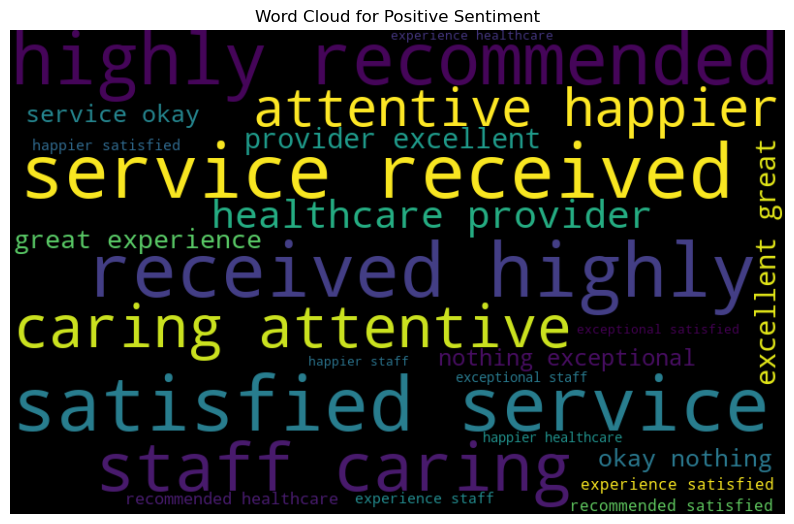

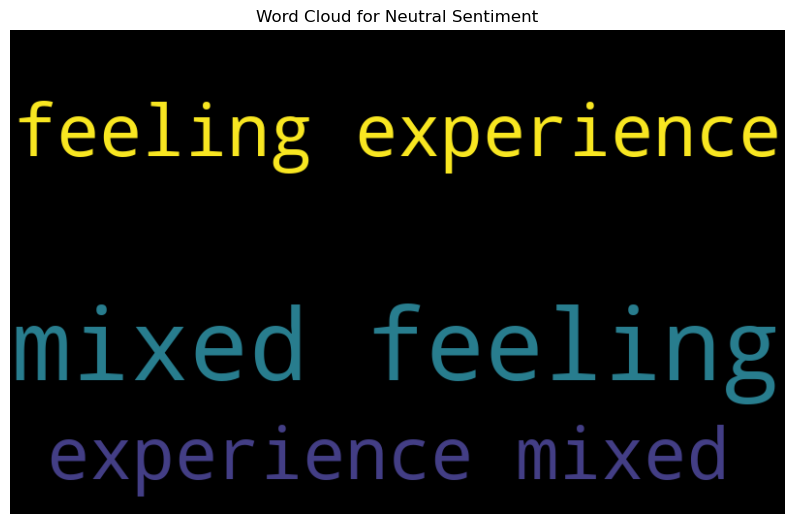

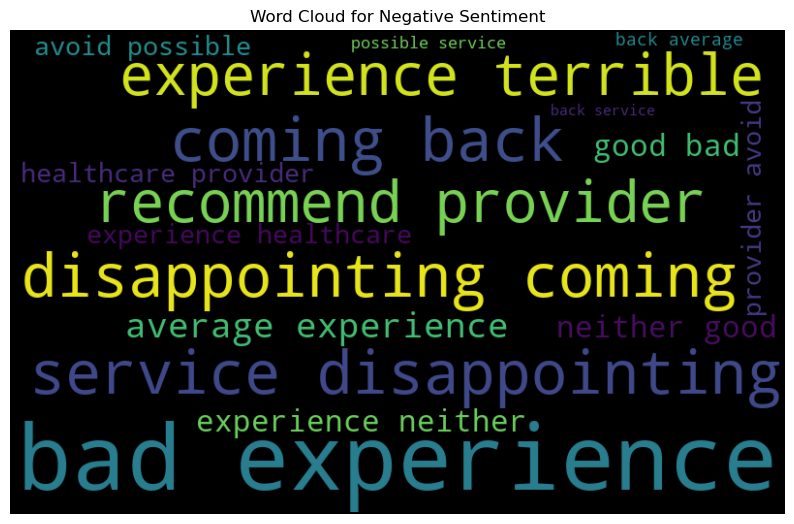

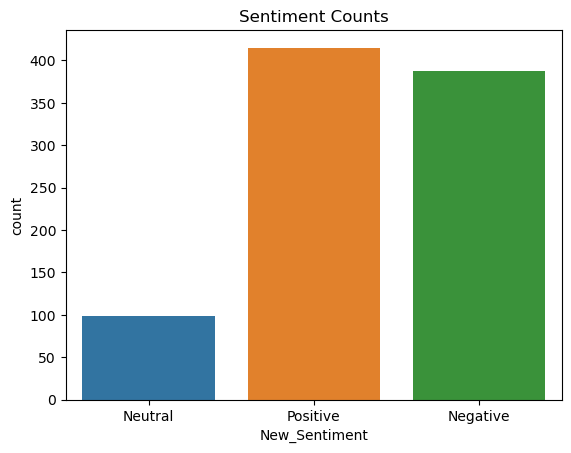

In [193]:
from wordcloud import WordCloud
# Generate word cloud for positive sentiment
positive_text = ' '.join(df_reset[df_reset['New_Sentiment']=='Positive']['Cleaned_Reviews'])
positive_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_text)

plt.figure(figsize=(10, 7))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

# Generate word cloud for neutral sentiment
neutral_text = ' '.join(df_reset[df_reset['New_Sentiment']=='Neutral']['Cleaned_Reviews'])
neutral_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neutral_text)

plt.figure(figsize=(10, 7))
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment')
plt.show()

negative_text = ' '.join(df_reset[df_reset['New_Sentiment']=='Negative']['Cleaned_Reviews'])
negative_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_text)

plt.figure(figsize=(10, 7))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

# Bar plot of sentiment counts
sns.countplot(x='New_Sentiment', data=df_reset)
plt.title('Sentiment Counts')
plt.show()


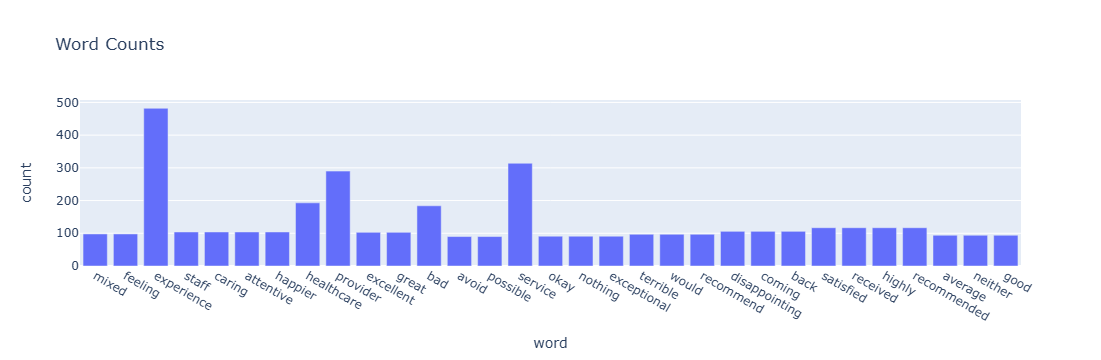

In [195]:
import plotly.express as px
from collections import Counter

# Assuming 'df' is your DataFrame and 'cleaned' column contains cleaned text
words = ' '.join(df_reset['Cleaned_Reviews']).split()
word_counts = Counter(words)

word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
word_counts_df.columns = ['word', 'count']

fig = px.bar(word_counts_df, x='word', y='count', title='Word Counts')
fig.show()


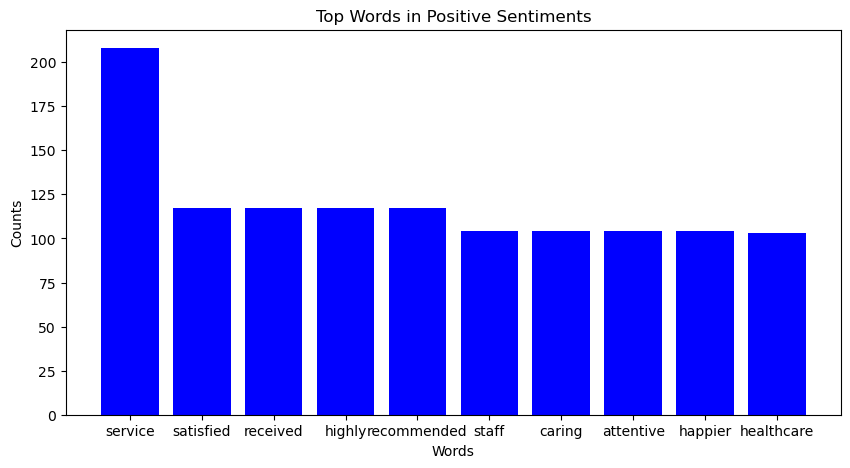

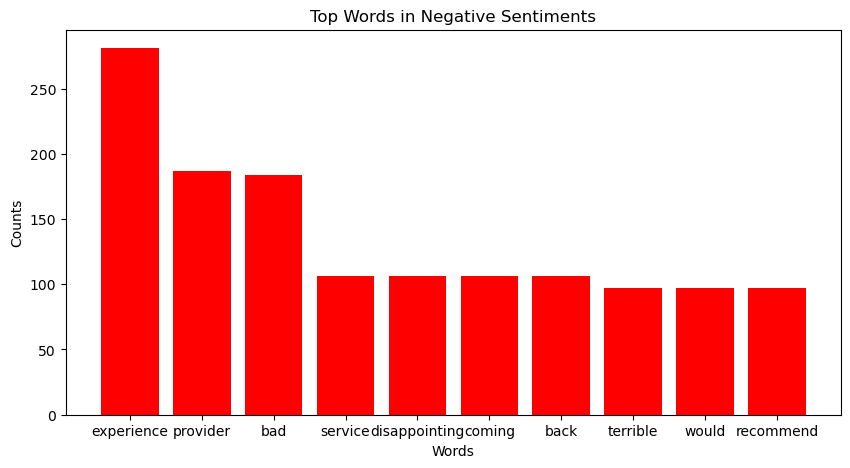

In [197]:
from collections import Counter

# Assuming 'cleaned' column contains cleaned reviews and 'Sentiment' column contains sentiment labels
positive_words = ' '.join(df_reset[df_reset['New_Sentiment']=='Positive']['Cleaned_Reviews']).split()
negative_words = ' '.join(df_reset[df_reset['New_Sentiment']=='Negative']['Cleaned_Reviews']).split()

positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Get the 10 most common words in positive and negative sentiments
top_positive_words = positive_word_counts.most_common(10)
top_negative_words = negative_word_counts.most_common(10)

# Plot bar chart for top words in positive sentiments
plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_positive_words), color='b')
plt.title('Top Words in Positive Sentiments')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

# Plot bar chart for top words in negative sentiments
plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_negative_words), color='r')
plt.title('Top Words in Negative Sentiments')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()


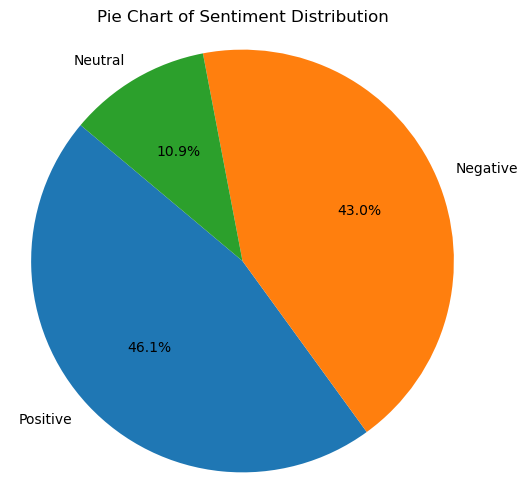

In [199]:
# Assuming 'Sentiment' column contains sentiment labels
sentiment_counts = df_reset['New_Sentiment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Pie Chart of Sentiment Distribution')
plt.show()


In [201]:
from sklearn.feature_extraction.text import CountVectorizer

In [203]:

cv = CountVectorizer(ngram_range=(1,2))
X = df_reset['Cleaned_Reviews'].tolist()
X_cv = cv.fit_transform(X)
y=df_reset['New_Sentiment'].values
dataset_analysis = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
dataset_analysis['New_Sentiment']=y
temp_df=dataset_analysis.query("New_Sentiment=='Positive'")
positive_df=pd.DataFrame()
positive_df['Words']=list(temp_df.iloc[:, :-1].columns)
positive_df['Frequency']=temp_df.iloc[:, :-1].sum().values
positive_df = positive_df.sort_values(by='Frequency',ascending=False)
positive_df.to_csv(r'positive_df_1.csv',index=False)

In [105]:
positive_df.head()


,Words,Frequency
87,the,415
96,wa,298
80,service,208
89,the service,208
77,recommended,117


In [205]:
positive_df[positive_df['Words'].str.split().apply(len)>1].sort_index()

,Words,Frequency
1,attentive happier,104
3,average experience,0
5,avoid possible,0
8,bad experience,0
10,caring attentive,104
12,coming back,0
14,disappointing coming,0
16,excellent great,103
19,experience healthcare,0
20,experience neither,0


In [207]:
positive_df[positive_df['Words'].str.split().apply(len) > 1].sort_index()


,Words,Frequency
1,attentive happier,104
3,average experience,0
5,avoid possible,0
8,bad experience,0
10,caring attentive,104
12,coming back,0
14,disappointing coming,0
16,excellent great,103
19,experience healthcare,0
20,experience neither,0


In [209]:
temp_df=dataset_analysis.query("New_Sentiment=='Negative'")

In [211]:
negative_df=pd.DataFrame()
negative_df['Words']=list(temp_df.iloc[:, :-1].columns)
negative_df['Frequency']=temp_df.iloc[:, :-1].sum().values
negative_df = negative_df.sort_values(by='Frequency',ascending=False)
negative_df.to_csv(r'negative_df_1.csv',index=False)

In [213]:

negative_df.head(10)

,Words,Frequency
18,experience,281
42,provider,187
7,bad,184
14,disappointing coming,106
52,service,106
53,service disappointing,106
6,back,106
11,coming,106
12,coming back,106
13,disappointing,106


In [215]:
negative_df[negative_df['Words'].str.split().apply(len) > 1].sort_index()

,Words,Frequency
1,attentive happier,0
3,average experience,94
5,avoid possible,90
8,bad experience,90
10,caring attentive,0
12,coming back,106
14,disappointing coming,106
16,excellent great,0
19,experience healthcare,90
20,experience neither,94


In [217]:
temp_df=dataset_analysis.query("New_Sentiment=='Neutral'")

In [219]:
neutral_df=pd.DataFrame()
neutral_df['Words']=list(temp_df.iloc[:, :-1].columns)
neutral_df['Frequency']=temp_df.iloc[:, :-1].sum().values
neutral_df = negative_df.sort_values(by='Frequency',ascending=False)
neutral_df.to_csv(r'neutral_df_1.csv',index=False)

In [221]:
neutral_df.head()

,Words,Frequency
18,experience,281
42,provider,187
7,bad,184
14,disappointing coming,106
52,service,106


In [32]:
neutral_df[neutral_df['Words'].str.split().apply(len) > 1].sort_index()

,Words,Frequency
1,attentive happier,0
3,average experience,94
5,avoid possible,90
8,bad experience,90
10,caring attentive,0
12,coming back,106
14,disappointing coming,106
16,excellent great,0
19,experience healthcare,90
20,experience neither,94


In [223]:
# Splitting the data into features and target
X = df_reset['Cleaned_Reviews']  # The cleaned text data
y = df_reset['New_Sentiment']      # The sentiment label (positive, negative, neutral)

In [225]:
X

0                            mixed feeling experience
1                      staff caring attentive happier
2                            mixed feeling experience
3                            mixed feeling experience
4      healthcare provider excellent great experience
                            ...                      
895      experience terrible would recommend provider
896                 service disappointing coming back
897                  service okay nothing exceptional
898                          mixed feeling experience
899                    staff caring attentive happier
Name: Cleaned_Reviews, Length: 900, dtype: object

In [129]:
y



0       Neutral
1      Positive
2       Neutral
3       Neutral
4      Positive
         ...   
895    Negative
896    Negative
897    Positive
898     Neutral
899    Positive
Name: New_Sentiment, Length: 900, dtype: object

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [229]:
print('X_train='+str(len(X_train)))
print('X_test='+str(len(X_test)))

X_train=720
X_test=180


In [231]:
print('y_train='+str(len(y_train)))
print('y_test='+str(len(y_test)))

y_train=720
y_test=180


In [233]:
import pprint
unique_labels, counts = np.unique(X_train, return_counts=True)
pprint.pprint(dict(zip(unique_labels, counts)))


{'average experience neither good bad': 74,
 'bad experience healthcare provider avoid possible': 74,
 'experience terrible would recommend provider': 77,
 'healthcare provider excellent great experience': 85,
 'mixed feeling experience': 82,
 'satisfied service received highly recommended': 89,
 'service disappointing coming back': 88,
 'service okay nothing exceptional': 76,
 'staff caring attentive happier': 75}


In [235]:

unique_labels, counts = np.unique(X_test, return_counts=True)
pprint.pprint(dict(zip(unique_labels, counts)))


{'average experience neither good bad': 20,
 'bad experience healthcare provider avoid possible': 16,
 'experience terrible would recommend provider': 20,
 'healthcare provider excellent great experience': 18,
 'mixed feeling experience': 16,
 'satisfied service received highly recommended': 28,
 'service disappointing coming back': 18,
 'service okay nothing exceptional': 15,
 'staff caring attentive happier': 29}


In [237]:

unique_labels, counts = np.unique(y_train, return_counts=True)
pprint.pprint(dict(zip(unique_labels, counts)))


{'Negative': 313, 'Neutral': 82, 'Positive': 325}


In [239]:

unique_labels, counts = np.unique(y_test, return_counts=True)
pprint.pprint(dict(zip(unique_labels, counts)))


{'Negative': 74, 'Neutral': 16, 'Positive': 90}


In [241]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Naive Bayes classifier

In [243]:
# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)


# Make predictions
y_pred = model.predict(X_test_tfidf)

In [245]:
unique_labels, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique_labels, counts)))


{'Negative': 74, 'Neutral': 16, 'Positive': 90}


In [247]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovo')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC-AUC: {roc_auc}')

print(confusion_matrix(y_test, y_pred))



Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
[[74  0  0]
 [ 0 16  0]
 [ 0  0 90]]


# LogisticRegression

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.00
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        74
     Neutral       1.00      1.00      1.00        16
    Positive       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

[[74  0  0]
 [ 0 16  0]
 [ 0  0 90]]


# Support Vector Classification (SVC):

In [251]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Train an SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Make predictions

y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate the model
print("SVM - Classification Report")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_svm))


SVM - Classification Report
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        74
     Neutral       1.00      1.00      1.00        16
    Positive       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

Confusion Matrix
[[74  0  0]
 [ 0 16  0]
 [ 0  0 90]]


# GradientBoostingClassifier

In [255]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)

# Train the model using the SMOTE-resampled data
gb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = gb.predict(X_test_tfidf)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        74
     Neutral       1.00      1.00      1.00        16
    Positive       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



# RandomForestClassifier

In [257]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}')
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Accuracy (Random Forest): 1.00
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        74
     Neutral       1.00      1.00      1.00        16
    Positive       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180

[[74  0  0]
 [ 0 16  0]
 [ 0  0 90]]


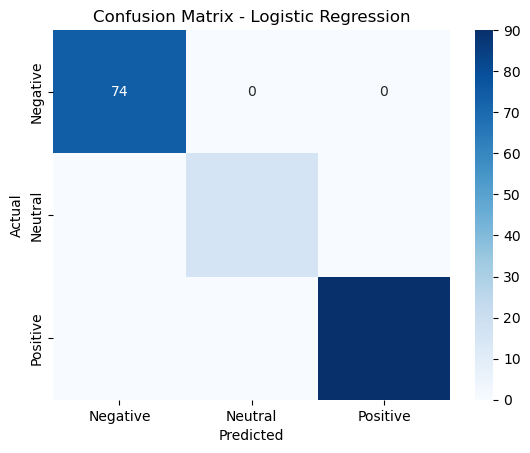

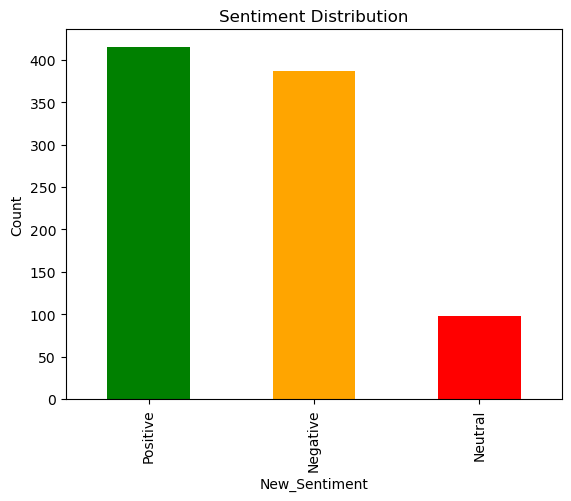

In [259]:

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Visualize the sentiment distribution
df_reset['New_Sentiment'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('New_Sentiment')
plt.ylabel('Count')
plt.show()


# HYPERPARAMETER TUNING

In [261]:
#HYPERPARAMETER TUNING

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method for sampling data points (with or without replacement)
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters
print(grid_search.best_params_)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [262]:
#HYPERPARAMETER TUNING
clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)


clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        74
     Neutral       1.00      1.00      1.00        16
    Positive       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [263]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

# Define the parameter grid
param_grid = {
    'n_estimators': sp_randInt(50, 200),
    'max_depth': sp_randInt(2, 10),
    'min_samples_split': sp_randFloat(),
    'min_samples_leaf': sp_randFloat(),
    'learning_rate': sp_randFloat()
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, n_iter=100, cv=3, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV object to the data
random_search.fit(X_train_tfidf, y_train)

# Print the best parameters
print(random_search.best_params_)


{'learning_rate': 0.15601864044243652, 'max_depth': 4, 'min_samples_leaf': 0.09997491581800289, 'min_samples_split': 0.45924889196586716, 'n_estimators': 166}


In [61]:
from sklearn.metrics import classification_report

# Create a new Gradient Boosting Classifier with the best parameters
gb = GradientBoostingClassifier(
    n_estimators=116,
    learning_rate=0.15601864044243652,
    max_depth=4,
    min_samples_split=0.45924889196586716,
    min_samples_leaf=0.09997491581800289,
    random_state=42
)

# Train the model using the SMOTE-resampled data
gb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = gb.predict(X_test_tfidf)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        74
     Neutral       1.00      1.00      1.00        16
    Positive       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [166]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train_tfidf, y_train, cv=3, scoring='accuracy')  # Example for classification
print(scores.mean())

1.0


In [67]:
This analysis provides actionable insights into patient feedback, helping healthcare providers enhance their services
based on the sentiment expressed in reviews.